In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    
    K = 0.125 # Cost

    def __init__(self, i:int, B:int, S:int, neighbors:list):
        self.i = i # Agent index
        self.B = B # True Believer (1 or -1)
        self.S = S # Strength of Convictions
        self.neighbors = neighbors # List of the Agent's Neighbors
        self.neighbors_num = len(neighbors) # N_i
        self.R = -1
        
        # Start-up Assumptions:
        self.C = self.B # Complianace (1 or -1)
        self.E = 0  # Enforcement (1, 0 or -1)

    def make_decision(self, lattice):
        if lattice.allow_conversion:
            if self.E != self.B:
                self.R = self.R - (.002 * self.E * self.B)
            else:
                self.R = 0
            
            if (self.R > self.S) and (self.B != self.C):
                self.B = self.C

        mean_social_pressure = lattice.get_social_pressure(self.neighbors) / self.neighbors_num

        # Make compliance decision  
        if self.B == 1:
            compliance = 1
        elif (-1 * self.B * mean_social_pressure) > self.S:
            compliance = -1 * self.B
        else:
            compliance = self.B

        # Mack enforcement decision
        W = (1 - (self.B * lattice.get_sum_of_compliance(self.neighbors) / self.neighbors_num)) / 2 # Need for enforcement 
        enforcement = 0
        if (self.B != compliance) and ((-1 * self.B * mean_social_pressure) > self.S + self.K):
            enforcement = -1 * self.B
        elif (self.B == compliance) and (self.S * W > self.K):
            enforcement = self.B

        self.C = compliance
        self.E = enforcement
    
class Lattice:
    
    def __init__(self, network_type:str, ture_believers_perc:float, allow_conversion=False, agents_num=1000):
        self.agents_num = agents_num
        self.ture_believers_perc = ture_believers_perc
        self.adjacent_list = []
        self.agents = []
        self.allow_conversion = allow_conversion
        self.t = 0 # Time / Round number

        if network_type == "1": # Unembedded 
            self.create_network(embedded=False)
            self.create_agents(clustered=False)
        
        elif network_type == "2": # Embedded & Randomly Distributed
            self.create_network(embedded=True)
            self.create_agents(clustered=False)
        
        elif network_type == "3": # Embedded & Clusterd
            self.create_network(embedded=True)
            self.create_agents(clustered=True)
            
    def create_network(self, embedded, row=25, col=40): # Make adjacent list of network
        # Unembedded (Fully conntected)   
        if not embedded:
            all_nodes_set = set(range(self.agents_num))
            for i in range(self.agents_num):
                self.adjacent_list.append(list(all_nodes_set-{i}))

        # Embedded (Moore neighborhood)
        else:
            if col * row != self.agents_num:
                raise Exception('Lattice size not equals to number of agents!') 
            for agent_index in range(self.agents_num):
                neighbors = []
                x = int(agent_index / col)
                y = agent_index % col
                for i in (-1, 0, 1):
                    for j in (-1, 0, 1):
                        x_ = x + i
                        y_ = y + j
                        if (i, j) != (0, 0):
                            # lattice is wrapping
                            if x_ == -1: x_ = row-1
                            if y_ == -1: y_ = col-1
                            if x_ == row: x_ = 0
                            if y_ == col: y_ = 0
                            neighbors.append(x_*col + y_)
                self.adjacent_list.append(neighbors)

    def create_agents(self, clustered):
        self.believers_num = int(self.agents_num * self.ture_believers_perc)

        # Pick who becomes believers
        ## Randomly Distributed
        if not clustered:
            self.believers_index = random.sample(range(self.agents_num), self.believers_num)
        
        ## Clusterd
        else:
            self.believers_index = set()
            self.believers_index.add(random.randint(0, self.agents_num-1)) # pick first believers

            # 對目前是 believer 那些 agent，從他們的所有鄰居來挑下一位成為 believer（也就是只有自己的鄰居中有 believer 的人，才可能會成為 believer），重複執行到指定的 believer 數量。
            for i in range(self.believers_num-1): 
                neighbors_of_believers = set()
                for b in self.believers_index:
                    neighbors_of_believers = neighbors_of_believers | set(self.adjacent_list[b])
                self.believers_index.add(random.choice(list(neighbors_of_believers-self.believers_index)))

        for i in range(self.agents_num):
            if i in self.believers_index:
                self.agents.append(Agent(i, 1, 1, self.adjacent_list[i])) # True Believers (B = 1)
            else:
                self.agents.append(Agent(i, -1, random.uniform(0, .38), self.adjacent_list[i])) # Disblievers (B = -1)

    def one_round(self):
        self.t += 1
        agents_index = list(range(self.agents_num))
        random.shuffle(agents_index)
        for i in agents_index:
            self.agents[i].make_decision(self)   

    def get_social_pressure(self, agents_list):
        return sum([self.agents[agent_index].E for agent_index in agents_list])
    
    def get_sum_of_compliance(self, agents_list):
        return sum([self.agents[agent_index].C for agent_index in agents_list])

    def get_disbeliever_compliance_perc(self):
        disbeliever = [a for a in self.agents if a.B == -1]
        false_compliance = [f for f in disbeliever if f.C == 1]
        return len(false_compliance) / len(disbeliever)

    def get_disbeliever_enforcement_perc(self):
        disbeliever = [a for a in self.agents if a.B == -1]
        false_enforcement = [f for f in disbeliever if f.E == 1]
        return len(false_enforcement) / len(disbeliever)
        
    def get_compliance_perc(self):
        return len([a for a in self.agents if a.C == 1]) / self.agents_num

    def get_enforcement_perc(self):
        return len([a for a in self.agents if a.E == 1]) / self.agents_num

In [38]:
# random.seed(12)
y = []
MyLattice = Lattice("3", 0.3)
round_num = 300
for r in range(round_num):
    MyLattice.one_round()
    y.append(MyLattice.get_disbeliever_enforcement_perc())
    # y.append(MyLattice.get_disbeliever_compliance_perc())

print(MyLattice.believers_num)
print(sum(y[-100:])/len(y[-100:]))   
print(sum(y)/len(y))

300
0.9283000000000002
0.8948333333333327


0.9371428571428572


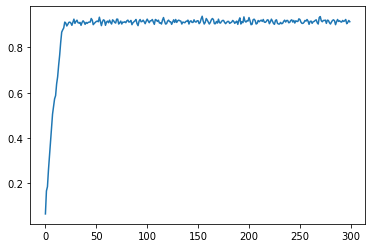

In [27]:
print(max(y))
plt.plot(y)
plt.show()

# FIG. 1.

In [208]:
random.seed(12)
ture_believers_perc = np.append(np.arange(0, .91, .05), [.995])

trial_num = 1

# Unembedded
round_num = 7
y1 = []
for x in ture_believers_perc:
    one_x_record = []
    for trial in range(trial_num):
        one_trail_record = []
        MyLattice = Lattice("1", x)
        for r in range(round_num):
            MyLattice.one_round()
            one_trail_record.append(MyLattice.get_disbeliever_compliance_perc())
        one_x_record.append(sum(one_trail_record[1:])/len(one_trail_record[1:]))
    y1.append(sum(one_x_record) / len(one_x_record))

# Embedded & Randomly Distributed
round_num = 300
y2 = []
for x in ture_believers_perc:
    one_x_record = []
    for trial in range(trial_num):
        one_trail_record = []
        MyLattice = Lattice("2", x)
        for r in range(round_num):
            MyLattice.one_round()
            one_trail_record.append(MyLattice.get_disbeliever_enforcement_perc())
        one_x_record.append(sum(one_trail_record[-100:])/len(one_trail_record[-100:]))
    y2.append(sum(one_x_record) / len(one_x_record))

# Embedded & Clustered 
round_num = 300
y3 = []
for x in ture_believers_perc:
    one_x_record = []
    for trial in range(trial_num):
        one_trail_record = []
        MyLattice = Lattice("3", x)
        for r in range(round_num):
            MyLattice.one_round()
            one_trail_record.append(MyLattice.get_disbeliever_enforcement_perc())
        one_x_record.append(sum(one_trail_record[-100:])/len(one_trail_record[-100:]))
    y3.append(sum(one_x_record) / len(one_x_record))

1 300


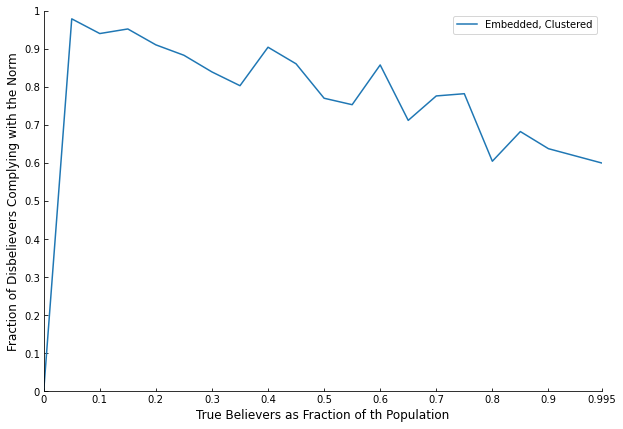

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(ture_believers_perc, y1, label='Unembedded')
ax.plot(ture_believers_perc, y2, label='Embedded, Randomly Distributed')
ax.plot(ture_believers_perc, y3, label='Embedded, Clustered')

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_xlim(0, .995)   
ax.set_xticks(np.append(np.arange(0, .91, .1), [.995]))
ax.tick_params(direction="in")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.set_ylabel("Fraction of Disbelievers Complying with the Norm", rotation=90, y=0.5, fontsize=12)
ax.set_xlabel("True Believers as Fraction of th Population", fontsize=12)

fig.set_facecolor('white')
plt.legend()

# plt.savefig('FIG1.png')
print(trial_num, round_num)
plt.show()

In [59]:
random.seed(12)
ture_believers_perc = np.arange(0, .031, .001)

trial_num = 100

# Embedded & Randomly Distributed
round_num = 300
y2 = []
for x in ture_believers_perc:
    one_x_record = []
    for trial in range(trial_num):
        one_trail_record = []
        MyLattice = Lattice("2", x)
        for r in range(round_num):
            MyLattice.one_round()
            one_trail_record.append(MyLattice.get_disbeliever_enforcement_perc())
        one_x_record.append(sum(one_trail_record[-100:])/len(one_trail_record[-100:]))
    y2.append(sum(one_x_record) / len(one_x_record))
    # print(round(x, 3), end=", ")
# print('-'*10)

# Embedded & Clustered 
round_num = 300
y3 = []
for x in ture_believers_perc:
    one_x_record = []
    for trial in range(trial_num):
        one_trail_record = []
        MyLattice = Lattice("3", x)
        for r in range(round_num):
            MyLattice.one_round()
            one_trail_record.append(MyLattice.get_disbeliever_enforcement_perc())
        one_x_record.append(sum(one_trail_record[-100:])/len(one_trail_record[-100:]))
    y3.append(sum(one_x_record) / len(one_x_record))
    # print(round(x, 3), end=", ")

0.0, 0.001, 0.002, 

KeyboardInterrupt: 

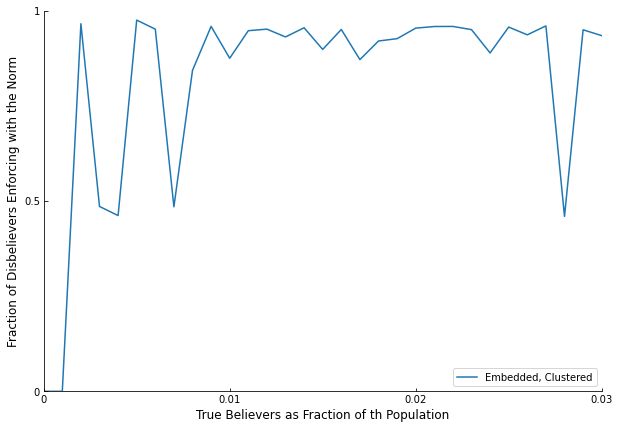

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(ture_believers_perc, y2, label='Embedded, Randomly Distributed')
ax.plot(ture_believers_perc, y3, label='Embedded, Clustered')

ax.set_ylim(0, 1)
ax.set_yticks(np.array([0, 0.5, 1]))
ax.set_xlim(0, .03)   
ax.set_xticks(np.array([0, 0.01, 0.02, 0.03]))
ax.tick_params(direction="in")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.set_ylabel("Fraction of Disbelievers Enforcing with the Norm", rotation=90, y=0.5, fontsize=12)
ax.set_xlabel("True Believers as Fraction of th Population", fontsize=12)

fig.set_facecolor('white')
plt.legend()
# plt.savefig('FIG1-2.png')
plt.show()

# FIG. 3.

In [11]:
random.seed(42)
y1 = []
y2 = []
MyLattice = Lattice("3", 0.01, allow_conversion=True)
round_num = 800
for r in range(round_num):
    MyLattice.one_round()
    y1.append(MyLattice.get_compliance_perc())
    y2.append(MyLattice.get_enforcement_perc())

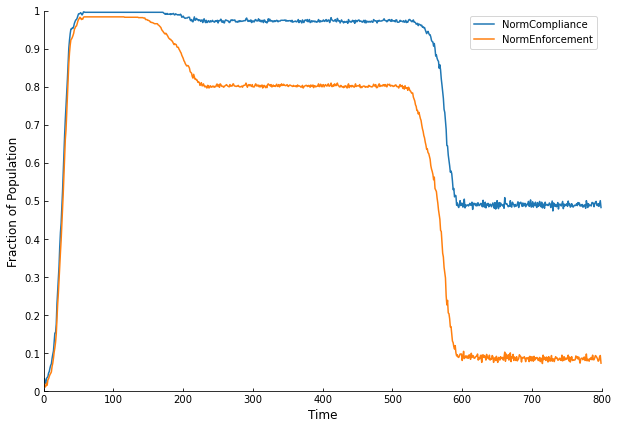

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(y1, label='NormCompliance')
ax.plot(y2, label='NormEnforcement')

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(0, 800)   
ax.set_xticks(np.arange(0, 801, 100))
ax.tick_params(direction="in")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.set_ylabel("Fraction of Population", rotation=90, y=0.5, fontsize=12)
ax.set_xlabel("Time", fontsize=12)

fig.set_facecolor('white')
plt.legend()
plt.savefig('FIG3.jpg')
plt.show()

# Utilities

In [4]:
# Make sure the mean of all disbelievers' Strength is 0.19
stop = False
t = 0
while not stop:
    a = np.random.uniform(0,.38, 1000)
    t += 1
    if round(a.mean(), 5) == .19:
        stop = True
print(t, a.mean())

411 0.18999983266898185


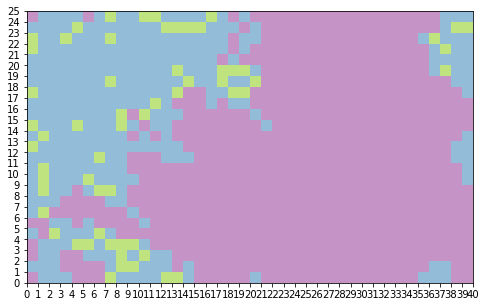

In [39]:
# Plot lattice
random.seed(12)
# MyLattice = Lattice("2", 0.3)
# for r in range(300):
#     MyLattice.one_round()
believers_index = MyLattice.believers_index

row, col = 25, 40
map = np.full((row, col), 0)
for b in believers_index:
    x = int(b/col)
    y = b%col
    map[x, y] = 1

for i in range(MyLattice.agents_num):
    x, y = int(i/col), i%col
    if MyLattice.agents[i].B == -1:
        map[x, y] = 2
    if MyLattice.agents[i].B == -1 and MyLattice.agents[i].C == 1:
        map[x, y] = 2
    if MyLattice.agents[i].B == -1 and MyLattice.agents[i].E == 1:
        map[x, y] = 3

tick_gap = 1000
show_grid = False
plt.figure(figsize=(8, 5))
plt.pcolormesh(map, cmap='Set3', alpha = 0.85, vmin=-0.5, vmax=4) 
ax = plt.gca();
ax.set_xticks(np.arange(0, col+1, 1))
ax.set_yticks(np.arange(0, row+1, 1))
if show_grid:
    ax.grid(c='black', linestyle='-', linewidth=.75)

plt.show()

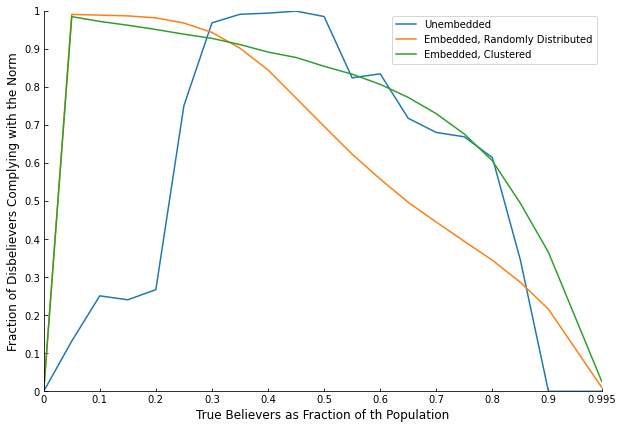

In [3]:
import csv

with open('data.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    data = list(csv_reader)

ture_believers_perc = np.append(np.arange(0, .91, .05), [.995])
y1 = [float(x) for x in data[0]]
y2 = [float(x) for x in data[1]]
y3 = [float(x) for x in data[2]]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(ture_believers_perc, y1, label='Unembedded')
ax.plot(ture_believers_perc, y2, label='Embedded, Randomly Distributed')
ax.plot(ture_believers_perc, y3, label='Embedded, Clustered')

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_xlim(0, .995)   
ax.set_xticks(np.append(np.arange(0, .91, .1), [.995]))
ax.tick_params(direction="in")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.set_ylabel("Fraction of Disbelievers Complying with the Norm", rotation=90, y=0.5, fontsize=12)
ax.set_xlabel("True Believers as Fraction of th Population", fontsize=12)

fig.set_facecolor('white')
plt.legend()
plt.show()